# 03 - Algorithm

So, we separated some samples in [01 - Take Samples](01_take_samples.ipynb) and rescaled the images and created grayscale copies in [02 - Preprocess](02_preprocess.ipynb). Now it is the time to see if we can fit a machine learning algorithm that can perform the task: Detecting objects in images by using outlier detection. For this we will perform the following tasks:

* Using a method to partition an image in non-overlapping patches of a predefined shape.
* Creating a set of features to describe the block.
    * Currently implemented: **Intensity histogram**
* Fitting an outlier detection algorithm to predict if that block contains an object.
* Rebuild the image and visualize the outcome :)

If the task is successful we can later try to create a herustic to create bounding boxes.

## Imports

In [1]:
import pandas as pd
import numpy as np
import imageio
from skimage.util import view_as_blocks
from sklearn.ensemble import IsolationForest
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt

from funcs.preprocessing import read_data
from funcs.plot import show_image
from funcs.ml import read_images, images_as_patches, prediction_intensities, reconstruct_image, IntensityHistogram

In [2]:
plt.rcParams['figure.figsize'] = (12,8)

Let's start with the grayscale images

In [3]:
gray_train_val_images, train_val_annotations = read_data('gray_', 'resized_')

## Creating patches

To split an image into patches we can use the `view_as_blocks` function from `skimage`. It will create non-overlapping blocks of the image, given a patch size.

Since we rescaled our images to be 1024x1024, we can use any power of 2 as the block size and we will have the complete image as blocks.

Let's try a silly example using 512 as the block size.

In [4]:
img = imageio.imread(gray_train_val_images.iloc[0, -1])

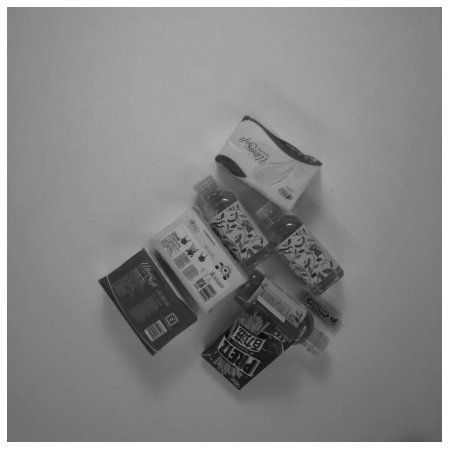

In [5]:
plt.imshow(img, cmap='gray')

plt.axis('off')
plt.show()

In [6]:
img_blocks = view_as_blocks(img, (512,512)).reshape(-1, 512, 512)

img_blocks.shape

(4, 512, 512)

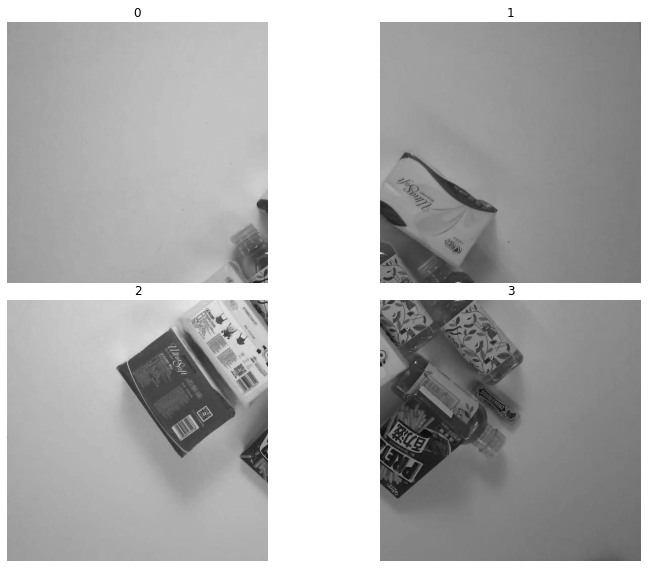

In [7]:
fig, axs = plt.subplots(nrows=2, ncols=2)

axs = axs.flatten()

for i, ax in zip(range(img_blocks.shape[0]), axs):

    ax.imshow(img_blocks[i, :, :], cmap='gray')
    ax.set_title(str(i))
    ax.axis('off')

fig.tight_layout(h_pad=0.1)
plt.show()

Of course there is a trade-off when selecting the patch size where smaller sizes will lead to more specific information, and possibly better to detect nuances in the images, while bigger blocks will lead to more information at the cost of the specificity.

We can also easily reconstruct the image

(512, 1024)


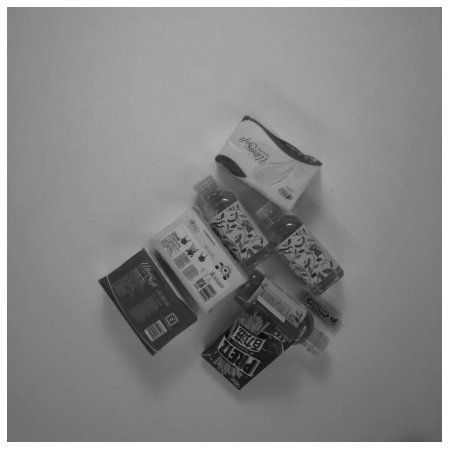

In [8]:
# We first have to stack the images along the rows (ie expand the images row-wise)
first_half = np.hstack(img_blocks[:2, :, :])
print(first_half.shape)
second_half = np.hstack(img_blocks[2:, :, :])

# Then just put each half on top of each other
reconstructed_image = np.vstack((first_half, second_half))

plt.imshow(reconstructed_image, cmap='gray')

plt.axis('off')
plt.show()

## Histogram

One way to describe an image is using an histogram of intensities. The histogram will compute the frequency of each intensity, given that it belongs to a specific bin.

The bin size is usually learned from the data, and since we will be working with images some varying distribution of intesities, it would be wise to standardize the bin ranges.

We can do that by setting the `bins` and `range` parameters of `numpy.histogram`

In [9]:
img2 = imageio.imread(gray_train_val_images.iloc[1, -1]) # Let's take another image

In [10]:
# Even tough the images have different distributions, its edges appear to be the same
hist, edges = np.histogram(img, bins=128, range=(0, 255))
hist2, edges2 = np.histogram(img2, bins=128, range=(0, 255))

diff_edges = edges-edges2

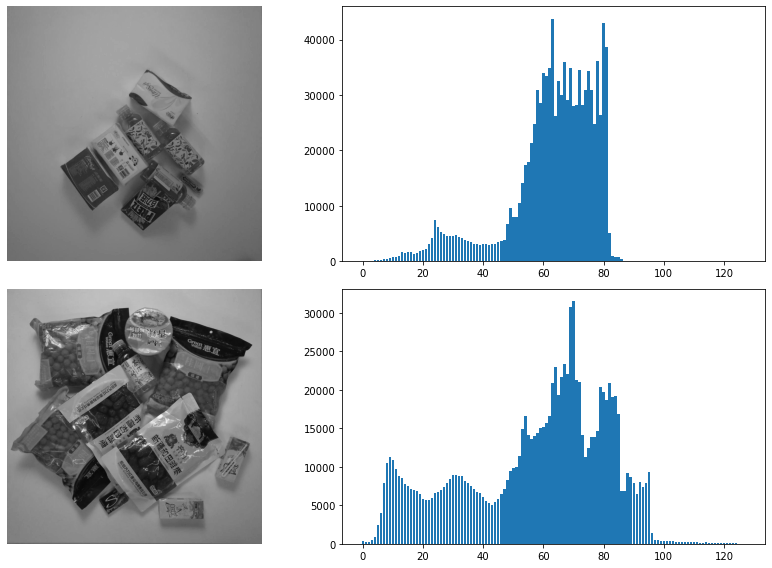

In [11]:
fig, axs = plt.subplots(nrows=2, ncols=2)

axs = axs.flatten()

axs[0].imshow(img, cmap='gray')
axs[0].axis('off')
axs[1].bar(range(128), hist)

axs[2].imshow(img2, cmap='gray')
axs[2].axis('off')
axs[3].bar(range(128), hist2)

fig.tight_layout()
plt.show()

The edges are also the same

In [12]:
print(diff_edges.sum())
print(diff_edges.max())
print(diff_edges.min())

0.0
0.0
0.0


Let's see the histogram distribution of our patches defined beforehand to get a general idea of what we are trying to accomplish

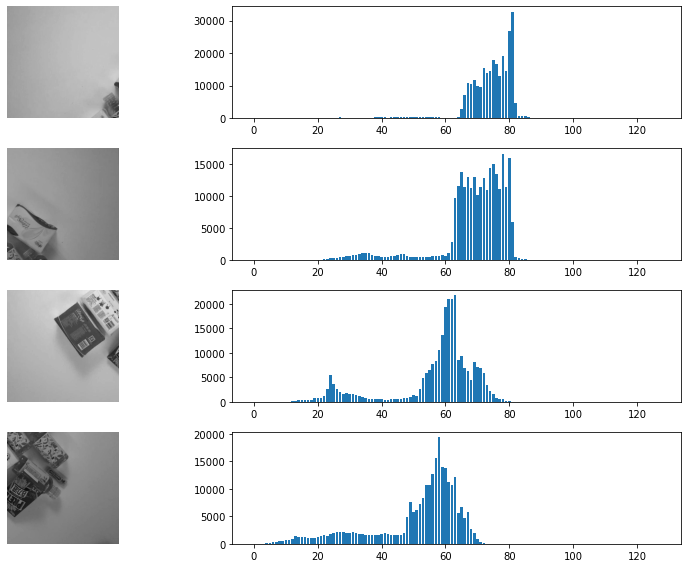

In [13]:
fig, axs = plt.subplots(nrows=4, ncols=2)

for i in range(img_blocks.shape[0]):

    hist, edges = np.histogram(img_blocks[i, :, :], bins=128, range=(0, 255))
    axs[i, 0].imshow(img_blocks[i, :, :], cmap='gray')
    axs[i, 0].axis('off')
    axs[i, 1].bar(range(128), hist)

fig.tight_layout()
plt.show()

## Feature descriptors

Now we have to wrap everything up. Read all our images, take the *n* patches of whichever size we want and take the intensity histogram of each of them.

For the first experiments, we will use a patch size of 64x64, which for each image should yield 256 patches.

In [14]:
train_idx = gray_train_val_images.loc[gray_train_val_images['source']=='train'].index.max()
val_idx = gray_train_val_images.loc[gray_train_val_images['source']=='validation'].index.max()

In [15]:
imgs_array = read_images(gray_train_val_images['file_name'])

train_imgs = imgs_array[:train_idx+1, :, :].copy()
val_imgs = imgs_array[train_idx:val_idx, :, :].copy()
test_imgs = imgs_array[val_idx+1:, :, :].copy()

In [16]:
print(train_imgs.shape)
print(val_imgs.shape)
print(test_imgs.shape)

(70, 1024, 1024)
(20, 1024, 1024)
(10, 1024, 1024)


In [17]:
train_set = images_as_patches(train_imgs, (1, 64, 64))

print(train_set.shape)

(17920, 4096)


## Fiting the IsoForest

We will use the Isolation Forest Algorithm. It has a nice propety that it returns the outlier propensity for each sample (i.e our patches), which we can later use as intensities to visualize how our detection algorithm is performing.

In [18]:
pipeline = Pipeline([('feature_descriptor', IntensityHistogram()), # Method to compute the intensity Histogram
                    ('clf', IsolationForest(n_jobs=-1, random_state=1))])

In [19]:
pipeline.fit(train_set)

Pipeline(steps=[('feature_descriptor', IntensityHistogram()),
                ('clf', IsolationForest(n_jobs=-1, random_state=1))])

In [20]:
pipeline.score_samples(train_set).shape

(17920,)

The algorithm uses an heuristic to define the cutpoint to classify each patch as an outlier

In [21]:
predicted_classes = pipeline.predict(train_set)

pd.Series(predicted_classes).value_counts()

 1    17725
-1      195
dtype: int64

But the raw scores might be more interesting

In [22]:
scores = pipeline.score_samples(train_set)

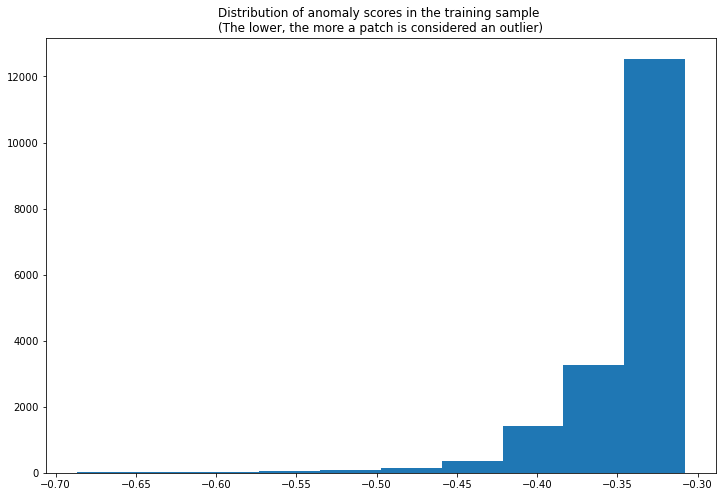

In [23]:
fig, ax = plt.subplots()

ax.hist(scores)
ax.set_title('Distribution of anomaly scores in the training sample \n(The lower, the more a patch is considered an outlier)')

plt.show()

#### Visualizing some training samples

Let's take a look at a couple of training samples, to get a better idea of the performance

In [24]:
ex_1 = train_imgs[0, :, :].copy()

In [25]:
ex_1_predictions = prediction_intensities(pipeline, ex_1, (64, 64))

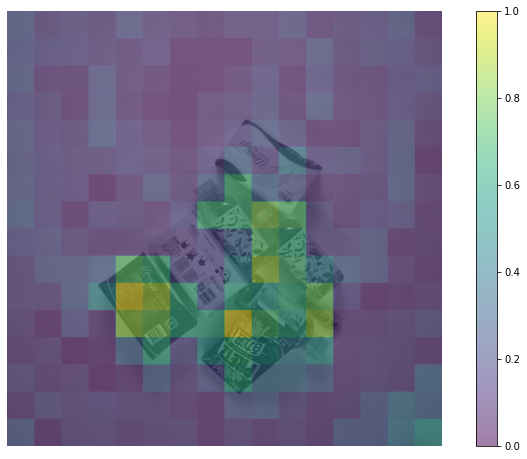

In [26]:
ax = show_image(gray_train_val_images['id'][0], gray_train_val_images)
im = ax.imshow(ex_1_predictions, alpha=0.5)

fig.colorbar(im, ax=ax)
plt.show()

Let's take a look at more samples

In [27]:
pos_ids = np.random.randint(low=0, high=train_imgs.shape[0], size=3)
train_df = gray_train_val_images.loc[gray_train_val_images['source']=='train']
sample_ids = train_df['id'].iloc[pos_ids].values

It certainly appears to do an okay job on the training set. The misses could be:

1. Objects that in grayscale blend better with the background
2. More convoluted images make less space for the background, confusing the algorithm

1 can be solved by using color while to solve 2 we can train the algorithm on the easy instances (that have less images)


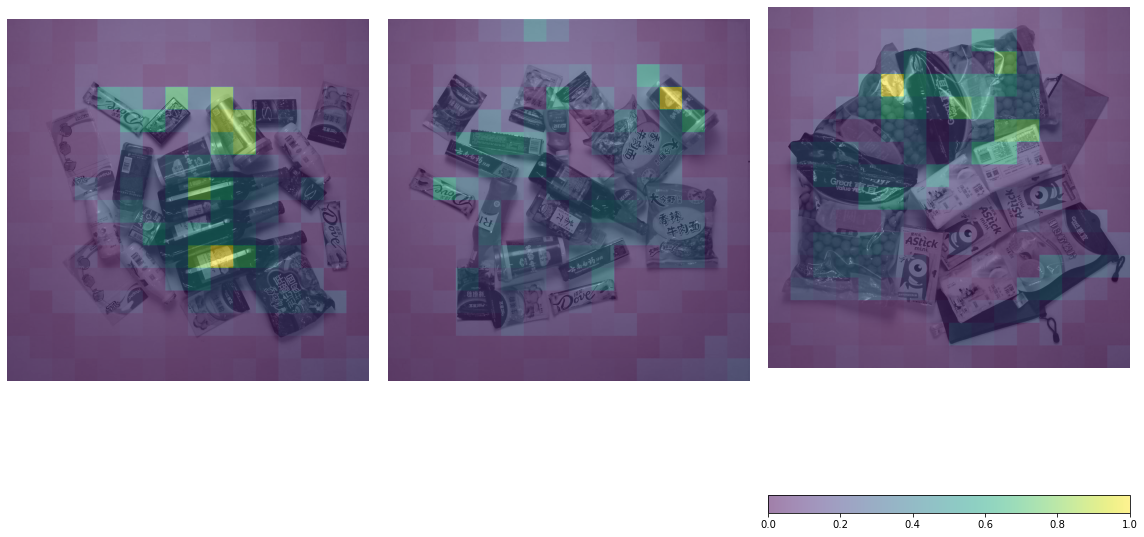

In [28]:
fig, axs = plt.subplots(ncols=3, figsize=(16,12))

for pos_id, id, ax in zip(pos_ids, sample_ids, axs):
    
    predictions = prediction_intensities(pipeline, train_imgs[pos_id], (64, 64))
    ax = show_image(id, gray_train_val_images, ax=ax)
    im = ax.imshow(predictions, alpha=0.5)

fig.colorbar(im, ax=axs[-1], orientation='horizontal')
fig.tight_layout(h_pad=0.1)
plt.show()


### Validation sample

Finally, let's look at the validation samples for a better understanding on how our object detection is working.

Most certainly this is a fairer assessment since the algorithm didn't use these images to train

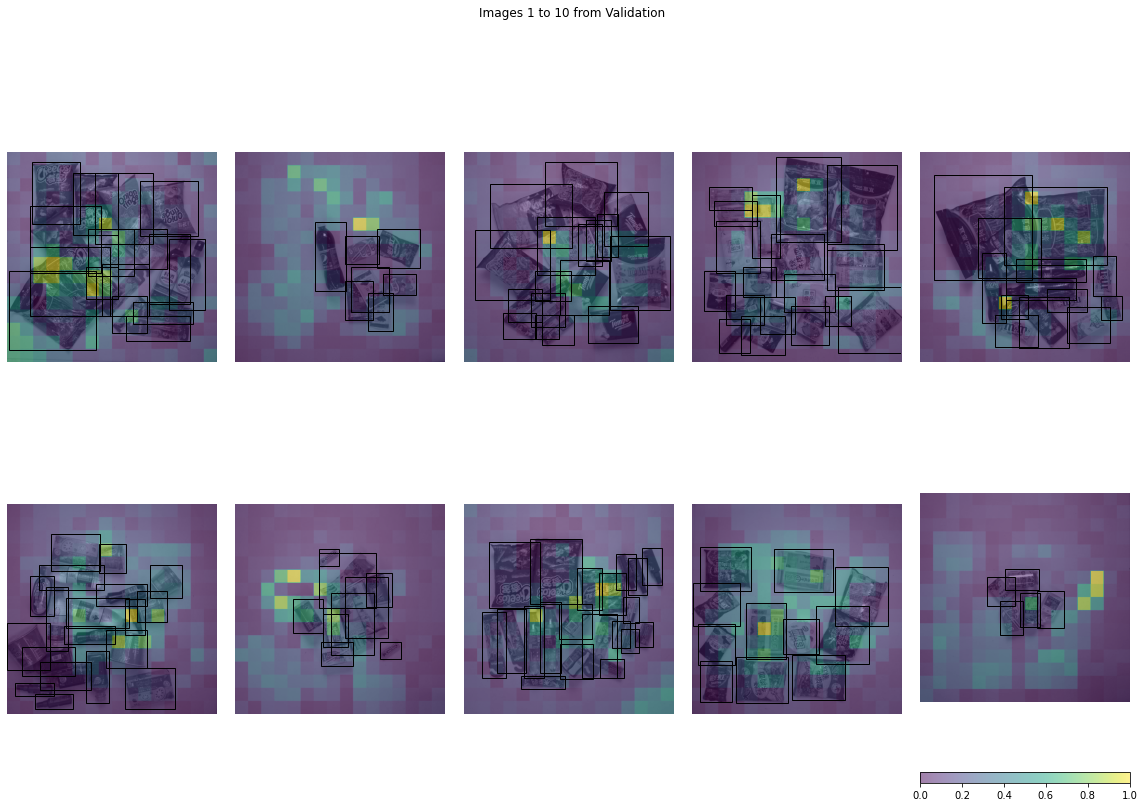

In [31]:
fig, axs = plt.subplots(nrows=2, ncols=5, figsize=(16, 12))

val_df = gray_train_val_images.loc[gray_train_val_images['source']=='validation']
axs = axs.flatten()

for i, ax in zip(range(10), axs):

    predictions = prediction_intensities(pipeline, val_imgs[i], (64, 64))
    id = val_df.iloc[i]['id']
    ax = show_image(id, gray_train_val_images, True, train_val_annotations, ax=ax)
    im = ax.imshow(predictions, alpha=0.5)

fig.suptitle('Images 1 to 10 from Validation')
fig.colorbar(im, ax=axs[-1], orientation='horizontal')
plt.tight_layout()
plt.savefig('.img/results_gray_1.png', facecolor='white', edgecolor='none')
plt.show()

It definitely seems that we are learning some objects positions from the train dataset and not extrapolating very well to out of the sample

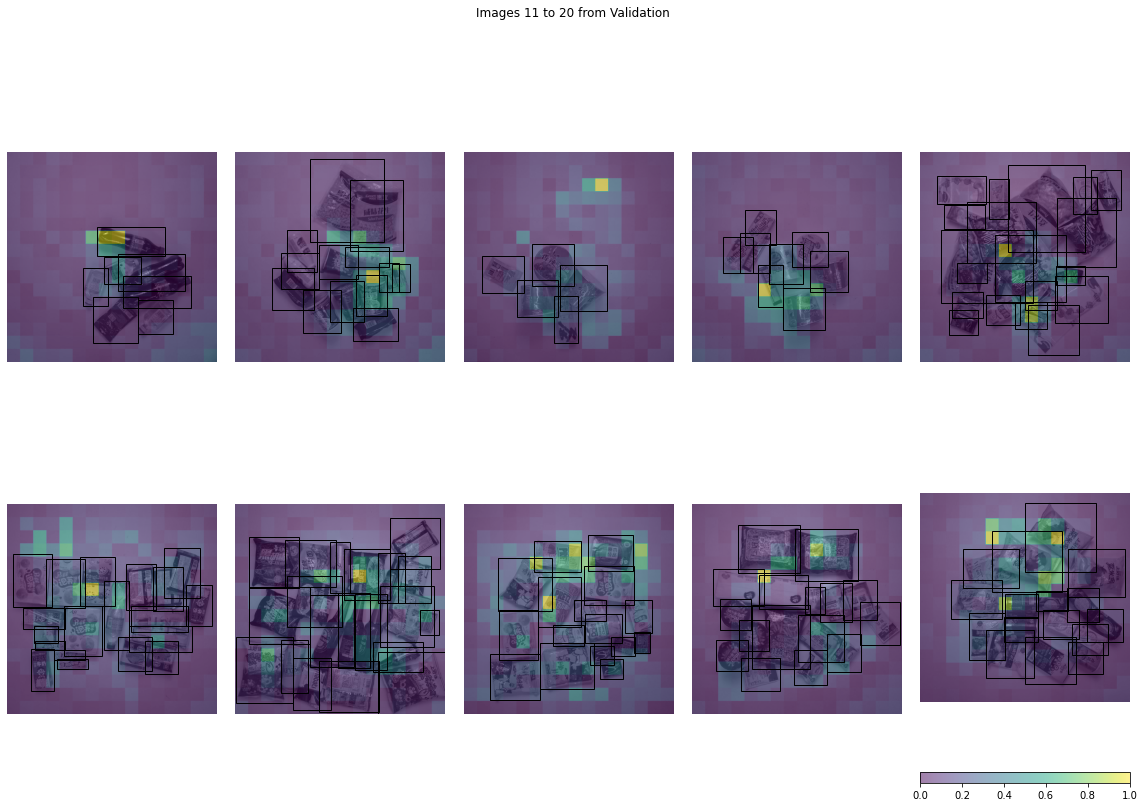

In [32]:
fig, axs = plt.subplots(nrows=2, ncols=5, figsize=(16, 12))

axs = axs.flatten()

for i, ax in zip(range(10, 20), axs):

    predictions = prediction_intensities(pipeline, val_imgs[i], (64, 64))
    id = val_df.iloc[i]['id']
    ax = show_image(id, gray_train_val_images, True, train_val_annotations, ax=ax)
    im = ax.imshow(predictions, alpha=0.5)

fig.suptitle('Images 11 to 20 from Validation')
fig.colorbar(im, ax=axs[-1], orientation='horizontal')
plt.tight_layout()
plt.savefig('.img/results_gray_2.png', facecolor='white', edgecolor='none')
plt.show()